In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
from NEF_RL import *
from fit import *
from plot_spikes import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

### Carrabin

In [2]:
trial = 2
sid = 1
alpha = 0.25
lambd = 0.0

env = EnvironmentRL(dataset='carrabin', sid=sid, trial=trial, alpha=alpha, z=0, lambd=lambd)
net, sim = simulate_RL(env=env, seed_net=sid, progress_bar=True)
B_0 = [get_expectations_carrabin("B_n", [0], sid, trial, stage) for stage in range(1,6)]
RL_0 = [get_expectations_carrabin("RL_n", [alpha, 0], sid, trial, stage) for stage in range(1,6)]
B_0.insert(0, 0)
RL_0.insert(0, 0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

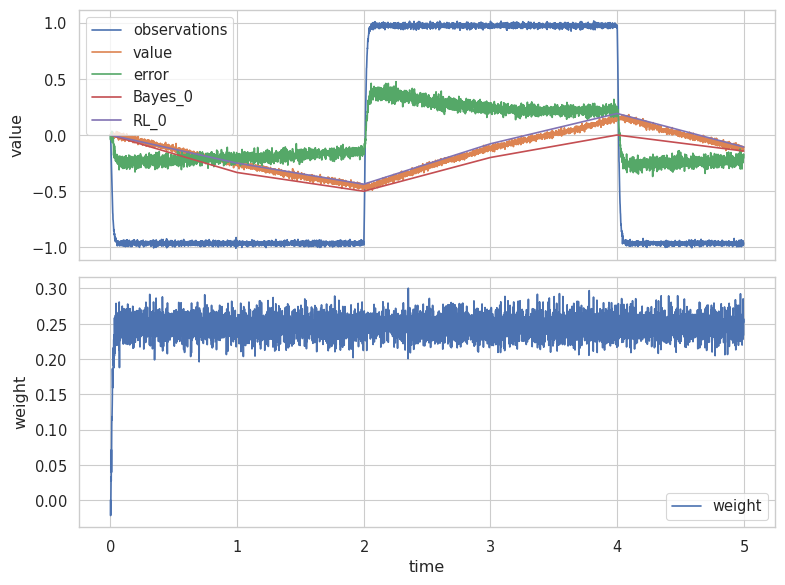

In [3]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
obs_times = np.arange(0, 6*env.T, env.T)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
    sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
    sns.lineplot(x=times, y=value, ax=axes[0], label='value')
    sns.lineplot(x=times, y=error, ax=axes[0], label='error')
    sns.lineplot(x=obs_times, y=B_0, ax=axes[0], label='Bayes_0')
    sns.lineplot(x=obs_times, y=RL_0, ax=axes[0], label='RL_0')
    sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
    axes[0].set(xlabel='time', ylabel='value')
    axes[1].set(xlabel='time', ylabel='weight', xticks=obs_times)
    plt.tight_layout()

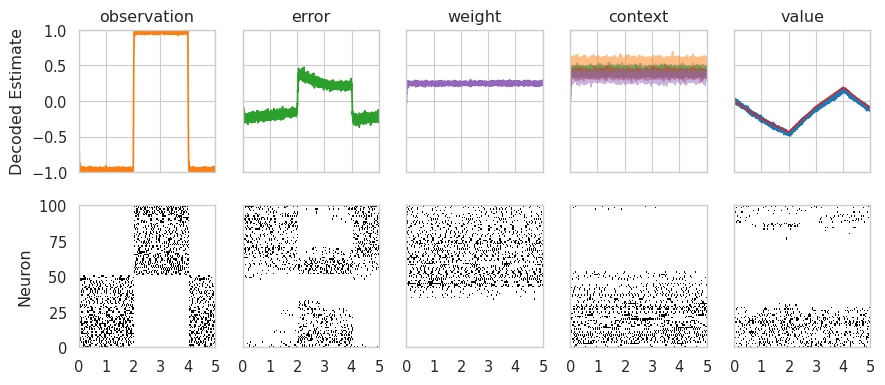

In [19]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
context = sim.data[net.probe_context]
obs_times = np.arange(0, 6*env.T, env.T)

obs_spikes = sim.data[net.probe_obs_spikes]
weight_spikes = sim.data[net.probe_weight_spikes]
error_spikes = np.hstack([sim.data[net.probe_error1_spikes], sim.data[net.probe_error2_spikes]])
value_spikes = sim.data[net.probe_value_spikes]
context_spikes = sim.data[net.probe_context_spikes]
times2, obs_spikes2 = preprocess_spikes(times, obs_spikes, num=100, sample_size=100)
times2, weight_spikes2 = preprocess_spikes(times, weight_spikes, num=100, sample_size=100)
times2, error_spikes2 = preprocess_spikes(times, error_spikes, num=100, sample_size=100)
times2, value_spikes2 = preprocess_spikes(times, value_spikes, num=100, sample_size=100)
times2, context_spikes2 = preprocess_spikes(times, context_spikes, num=100, sample_size=100)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(9,4), sharex=True, sharey='row')
    sns.lineplot(x=times, y=obs, ax=axes[0][0], color=palette[1])
    sns.lineplot(x=times, y=error, ax=axes[0][1], color=palette[2])
    sns.lineplot(x=times, y=weight, ax=axes[0][2], color=palette[4])
    for d in range(context.shape[1]):
        sns.lineplot(x=times, y=context[:,d], ax=axes[0][3], color=palette[d], alpha=0.5)
    sns.lineplot(x=times, y=value, ax=axes[0][4], color=palette[0])
    # sns.lineplot(x=obs_times, y=B_0, ax=axes[0][3], label='Bayes_0')
    sns.lineplot(x=obs_times, y=RL_0, ax=axes[0][4], color=palette[3])
    axes[0][0].set(title='observation', xlim=[0,5], ylim=[-1,1], xticks=range(6), ylabel='Decoded Estimate')
    axes[0][1].set(title='error')
    axes[0][2].set(title='weight')
    axes[0][3].set(title='context')
    axes[0][4].set(title='value')
with sns.axes_style("white"):
    # plot_spikes(times, obs_spikes, ax=axes[1][0])
    # plot_spikes(times, error_spikes, ax=axes[1][1])
    # plot_spikes(times, weight_spikes, ax=axes[1][2])
    # plot_spikes(times, value_spikes, ax=axes[1][3])
    plot_spikes(times2, obs_spikes2, ax=axes[1][0])
    plot_spikes(times2, error_spikes2, ax=axes[1][1])
    plot_spikes(times2, weight_spikes2, ax=axes[1][2])
    plot_spikes(times2, context_spikes2, ax=axes[1][3])
    plot_spikes(times2, value_spikes2, ax=axes[1][4])
    axes[1][0].grid(False)
    axes[1][1].grid(False)
    axes[1][2].grid(False)
    axes[1][3].grid(False)
    axes[1][4].grid(False)
    axes[1][0].set(ylabel='Neuron')
# axes[1].set(xlabel='time', ylabel='weight', xticks=obs_times)
plt.tight_layout()
fig.savefig("plots/dynamics_NEF_RL_demo.jpg", dpi=200)

### Jiang

In [2]:
trial = 1
sid = 1
z = 0.22
alpha = 0.26
# lambd = 0.0
lambd = 0.0
alpha_nef = alpha if lambd==0.0 else 1.0

env = EnvironmentRL(dataset='jiang', sid=sid, trial=trial, alpha=alpha_nef, z=z, lambd=lambd)
# net, sim = simulate_RL(env=env, seed_net=sid, progress_bar=True)
net, sim = simulate_RL(env=env, seed_net=sid, progress_bar=True)
DGz = get_expectations_jiang("DG_z", [z], sid, trial, stage=3, full=True)
RLz = get_expectations_jiang("RL_z", [alpha, z], sid, trial, stage=3, full=True)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

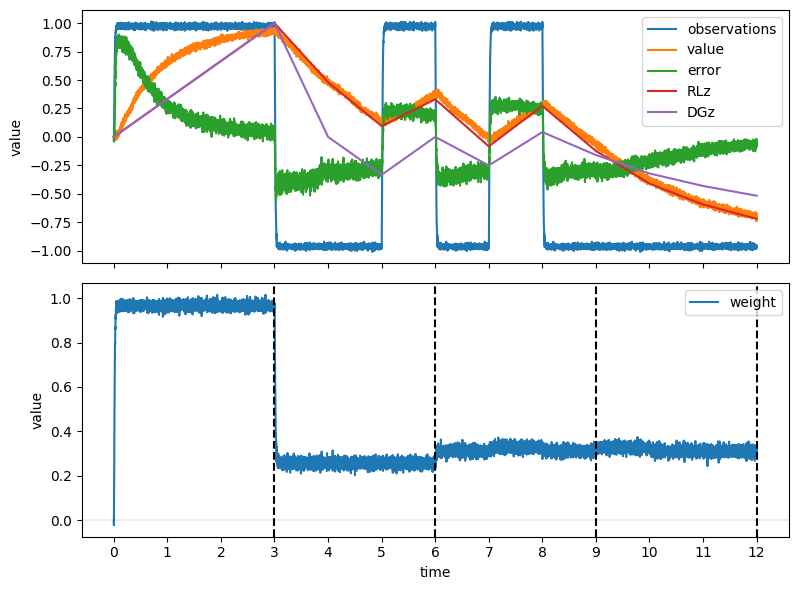

In [3]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
obs_times = np.arange(3*env.T, env.T+4*env.n_neighbors*env.T, env.T)
obs_times = list(obs_times)
obs_times.insert(0, 0)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=value, ax=axes[0], label='value')
sns.lineplot(x=times, y=error, ax=axes[0], label='error')
sns.lineplot(x=obs_times, y=RLz, ax=axes[0], label='RLz')
sns.lineplot(x=obs_times, y=DGz, ax=axes[0], label='DGz')
sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
axes[1].axhline(0, color='k', lw=0.1)
axes[1].axvline(3*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+env.n_neighbors*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+2*env.n_neighbors*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+3*env.n_neighbors*env.T, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+4*env.n_neighbors*env.T, env.T))  # , ylim=(0.0, 0.5)
plt.tight_layout()

In [28]:
pd.read_pickle('data/NEF_RL_carrabin_mar6_params.pkl')

,type,sid,alpha,n_all,lambda
0,NEF_RL,1,0.16,80,0.0
1,NEF_RL,2,0.26,50,0.0
2,NEF_RL,3,0.16,370,0.0
3,NEF_RL,4,0.86,10,0.0
4,NEF_RL,5,0.18,30,0.0
5,NEF_RL,6,0.34,60,0.0
6,NEF_RL,7,0.04,70,0.0
7,NEF_RL,8,0.36,30,0.0
8,NEF_RL,9,0.21,370,0.0
9,NEF_RL,10,0.09,60,0.0
